# Introduction
In this notebook we aim to simulate the orbital evolution of a planet in the presense of an additional force. We update accelerations which have been forced by arbitrary functions of $\dot{e}$ and $\dot{a}$. Equations used throughout this program are based on [Wolff, Dawson, & Murray-Clay (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/746/2/171/pdf), hereafter referenced as WDMC. (See also Chapter 2 of Murray & Dermott.) For reference, a page of this paper's appendix containing the relevant equations is shown below. 

![Image of Wolff et al. (2012) paper](WolffEquations.png)

# Problem
To model orbital evolution, we use two versions of code based on the equations shown in WDMC. As discussed in further detail below, one version was written by translating each equation directly from the appendix shown above. The second version is a Python translation based on a Fortran program which also used the same equations. Despite sharing the same mathematical foundation to model orbital evolution, the two versions of code produce difference results, as evidence by the plots below. Our goal in this document is to pinpoint the source(s) which causes a difference in results and to modify one or both versions in order to achieve convergent results. 

![Version 1](plots/orbitalEvolution_2019-05-28_09:54:22.248579.png)
![Version 2](plots/orbitalEvolution_2019-05-28_09:56:47.700251.png)


Although Version 1 appears to produce a better match to theory, the Fortran code on which Version 2 is based is expected to achieve accurate results; bugs were introduced in translation. Furthermore, an obvious bug in the Version 1 plot is that the amplitude of simulation does not match that of theory. For the time being we are withholding solving this bug, in the hopes that reconcilation of the two versions may serendipitously fix it. 

# Understanding mercury6_2.for

The two subroutines in the Fortran program `mercury6_2.for` which concern us here are `MCO_X2EL.FOR` and `MFO_USER.FOR`. They contain equations sourced in Murray & Dermott (MD), who in chapter 2.8 write,

> We can now summarize an algorithm for transforming the position $(X,Y,Z)$ and velocity
$(\dot{X}, \dot{Y}, \dot{Z})$ of an object in an elliptical orbit in the standard reference
plane at a time $t$ to a set of six orbital elements, $a$, $e$, $I$, $\Omega$, $\omega$, and $f$,
and a time of pericenter passage, $\tau$.

Below we show the subroutine with additional in-line comments that reference equations from the text. 

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MCO_X2EL.FOR    (ErikSoft  23 January 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Calculates Keplerian orbital elements given relative coordinates and
! velocities, and GM = G times the sum of the masses.
!
! The elements are: q = perihelion distance
!                   e = eccentricity
!                   i = inclination
!                   p = longitude of perihelion (NOT argument of perihelion!!)
!                   n = longitude of ascending node
!                   l = mean anomaly (or mean longitude if e < 1.e-8)
!
!------------------------------------------------------------------------------
!
      subroutine mco_x2el (gm,x,y,z,u,v,w,q,e,i,p,n,l)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      real*8 gm,q,e,i,p,n,l,x,y,z,u,v,w
!
! Local
      real*8 hx,hy,hz,h2,h,v2,r,rv,s,true
      real*8 ci,to,temp,tmp2,bige,f,cf,ce
!
!------------------------------------------------------------------------------
!
      hx = y * w  -  z * v ! MD (2.129)
      hy = z * u  -  x * w ! MD (2.129)
      hz = x * v  -  y * u ! MD (2.129)
      h2 = hx*hx + hy*hy + hz*hz ! MD (2.129)
      v2 = u * u  +  v * v  +  w * w ! MD (2.127)
      rv = x * u  +  y * v  +  z * w ! MD (2.128)
      r = sqrt(x*x + y*y + z*z) ! MD (2.126)
      h = sqrt(h2) ! MD (2.129)
      s = h2 / gm ! see MD (2.134) and (2.135)
!
! Inclination and node
      ci = hz / h ! MD (2.136)
      if (abs(ci).lt.1) then
        i = acos (ci) ! MD (2.136)
        n = atan2 (hx,-hy) ! MD (2.137)
        if (n.lt.0) n = n + TWOPI
      else
        if (ci.gt.0) i = 0.d0
        if (ci.lt.0) i = PI
        n = 0.d0
      end if
!
! Eccentricity and perihelion distance
      temp = 1.d0  +  s * (v2 / gm  -  2.d0 / r) ! MD (2.134) and (2.135)
      if (temp.le.0) then
        e = 0.d0
      else
        e = sqrt (temp) ! MD (2.134) and (2.135)
      end if
      q = s / (1.d0 + e) ! perihelion distance; see note below
!
! True longitude (aka θ; see MD chapter 2.3)
      if (hy.ne.0) then
        to = -hx/hy
        temp = (1.d0 - ci) * to
        tmp2 = to * to
        true = atan2((y*(1.d0+tmp2*ci)-x*temp),(x*(tmp2+ci)-y*temp))
      else
        true = atan2(y * ci, x)
      end if
      if (ci.lt.0) true = true + PI
!
      if (e.lt.3.d-8) then
        p = 0.d0
        l = true
      else
        ce = (v2*r - gm) / (e*gm)
!
! Mean anomaly for ellipse
        if (e.lt.1) then
          if (abs(ce).gt.1) ce = sign(1.d0,ce)
          bige = acos(ce)
          if (rv.lt.0) bige = TWOPI - bige
          l = bige - e*sin(bige)
        else
!
! Mean anomaly for hyperbola
          if (ce.lt.1) ce = 1.d0
          bige = log( ce + sqrt(ce*ce-1.d0) )
          if (rv.lt.0) bige = - bige
          l = e*sinh(bige) - bige
        end if
!
! Longitude of perihelion
        cf = (s - r) / (e*r)
        if (abs(cf).gt.1) cf = sign(1.d0,cf)
        f = acos(cf)
        if (rv.lt.0) f = TWOPI - f
        p = true - f
        p = mod (p + TWOPI + TWOPI, TWOPI)
      end if
!
      if (l.lt.0) l = l + TWOPI
      if (l.gt.TWOPI) l = mod (l, TWOPI)
!
!------------------------------------------------------------------------------
!
      return
      end
```

A few notes on some of the expressions. We note that the explicit expression of semimajor axis is bypassed by expressing $a$ as a function of eccentricity. Perihelion distance is defined as $r_p = a(1-e).$ With algebra we can show that $a = \frac{s}{(1-e)(1+e)}$. Therefore, $q\equiv r_p = \frac{s}{1+e}$.

```fortran
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
!      MFO_USER.FOR    (ErikSoft   2 March 2001)
!
!%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
!
! Author: John E. Chambers
!
! Applies an arbitrary force, defined by the user.
!
! If using with the symplectic algorithm MAL_MVS, the force should be
! small compared with the force from the central object.
! If using with the conservative Bulirsch-Stoer algorithm MAL_BS2, the
! force should not be a function of the velocities.
!
! N.B. All coordinates and velocities must be with respect to central body
! ===
!------------------------------------------------------------------------------
!
      subroutine mfo_user (time,jcen,nbod,nbig,m,x,v,a,vu)
!
      implicit none
      include 'mercury.inc'
!
! Input/Output
      integer nbod, nbig
      real*8 time,jcen(3),m(nbod),x(3,nbod),v(3,nbod),a(3,nbod)
      real*8 vu(3,nbod)
!
! Local
      integer j
      real*8 peri, drde,drfdotde,drdotde,r, msum, rdot, rfdot
      real*8 periq, e, inc, pomega, node, Manom, f, temp, semi
      real*8 adotovera, edotovere,idotoveri,taugravz,taugrav
      real*8 cs,vrand,vkep

!
!------------------------------------------------------------------------------
      adotovera=0.d0
         do j = 1, nbod
            a(1,j) = 0.d0
            a(2,j) = 0.d0
            a(3,j) = 0.d0
            vu(1,j) = 0.d0
            vu(2,j) = 0.d0
            vu(3,j) = 0.d0
            if (j .gt. 1 .and. j .le. nbig) then
              msum = m(1) + m(j)
              call mco_x2el (msum,x(1,j),x(2,j),x(3,j),v(1,j),v(2,j),v(3,j),periq, e, inc, pomega, node, Manom)
              semi = periq/(1.d0-e)
              taugravz=0.29*semi**2.0*m(1)/m(j)
              taugrav=taugravz

              cs=1.29/semi**0.25
              vkep=29.8/semi**0.5
              vrand=vkep*(e**2.0+inc**2.0)**0.5
              if(vrand.ge.cs.and.abs(inc).lt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**3.0                 
              end if
              if(abs(inc).gt.(cs/vkep)) then
                 taugrav=taugravz*(vrand/cs)**4.0                 
              end if

              edotovere=-1d0/(taugrav*365.25)
              idotoveri=2*edotovere

              if (edotovere.ne.0) then
                 if (e.eq.0) then
                    f = Manom
                 else
                    temp = (periq*(1.d0 + e)/(x(1,j)**2.d0+x(2,j)**2.d0+x(3,j)**2.d0)**(1.d0/2) - 1.d0) /e
                    temp = sign (min(abs(temp), 1.d0), temp)
                    f = acos(temp)
                    if (sin(Manom).lt.0) f = TWOPI - f
                 end if

                 r = semi * (1.d0-e**2.d0)/(1.d0+e*cos(f))
                 rdot = sqrt(msum)*semi**(-1.d0/2)*e*sin(f)*(1.d0-e**2.d0)**(-1.d0/2)
                 drdotde = rdot/(e*(1.d0-e**2.d0))
                 rfdot = sqrt(msum)*semi**(-1.d0/2)*(1.d0+e*cos(f))*(1.d0-e**2.d0)**(-1.d0/2)
                 drfdotde = rfdot*(e+cos(f))/((1.d0-e**2.d0)*(1.d0+e*cos(f)))
                 peri = mod(pomega - node + TWOPI, TWOPI)
                 drde = -2.d0*e*r/(1.d0-e**2.d0)-r**2.d0*cos(f)/(semi*(1.d0-e**2.d0))

              end if

               a(1,j) =  -(v(1,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(2,j) =  -(v(2,j)-3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               a(3,j) =  -(v(3,j)+3.d0*idotoveri*inc*x(3,j))/2.d0*adotovera
               vu(1,j) = x(1,j)*adotovera
               vu(2,j) = x(2,j)*adotovera
               vu(3,j) = x(3,j)*adotovera

               if (edotovere.ne.0.and.e.lt.1.and.e.gt.0) then
                    a(1,j) = a(1,j) + (cos(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             - sin(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(2,j) = a(2,j)+ (sin(node)*(drdotde*cos(peri+f)-drfdotde*sin(peri+f)) &
                             + cos(node)*(drdotde*cos(inc)*sin(peri+f)+drfdotde*cos(inc)*cos(peri+f) &
                             -drde*x(3,j)/r*idotoveri*inc))*edotovere*e
                    a(3,j) = a(3,j) + (drdotde*sin(inc)*sin(peri+f)+drfdotde*sin(inc)*cos(peri+f) &
                             +drde*cos(inc)*sin(peri+f)*idotoveri*inc)*edotovere*e
                    vu(1,j) = vu(1,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(1,j)*edotovere
                    vu(2,j) = vu(2,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(2,j)*edotovere
                    vu(3,j) = vu(3,j) + (r/(semi*(1.d0-e**2))-(1.d0+e**2)/(1.d0-e**2))*x(3,j)*edotovere
               end if

               if (idotoveri.ne.0) then
                   a(1,j) = a(1,j) + sin(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(2,j) = a(2,j) +  - cos(node)*(v(3,j)+x(3,j)*idotoveri)*idotoveri*inc
                   a(3,j) = a(3,j)+((-sin(node)*v(1,j)+cos(node)*v(2,j)) &
                            +idotoveri*(-sin(node)*x(1,j)+cos(node)*x(2,j)))*idotoveri*inc
                   vu(1,j) = vu(1,j)+x(3,j)*sin(node)*inc*idotoveri
                   vu(2,j) = vu(2,j)-x(3,j)*cos(node)*inc*idotoveri
                   vu(3,j) = vu(3,j)+(-x(1,j)*sin(node)+x(2,j)*cos(node))*inc*idotoveri
               end if
            end if
         end do


```

In [1]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
Mj = 955e-6 #...Jupiter mass in Solar units
import datetime
from mpl_toolkits.mplot3d import Axes3D

global e0, a0, Mp, Mstar
e0 = 0.468600
#e0 = 0.01
a0 = 0.238900
Mp = 0.00202983
Mstar = 0.927


"A function for the theoretical expectation of the evolution of eccentricity."
def theoryEvolution(e0,t,τ,evolType:str):
    if evolType == 'exp':
        e = e0*np.exp(-t/τ)
    elif evolType == 'trig':
        e = e0*(np.sin(2.*np.pi*t/τ) + 1)
    elif evolType == 'const':
        e = e0 * np.ones(len(t))
    return e


def setupSystem(e0=e0,a0=a0,Mp=Mp,Mstar=Mstar):
    sim = rebound.Simulation()
    sim.add(m=Mstar)
    sim.add(a=a0,e=e0,m=Mp,inc=np.radians(35.614629))#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim

def edotovereFxn(init_e,time,tau,e):
    return (2.0*np.pi*init_e/tau)*np.cos(2.0*np.pi*time/tau)/e


    


## Orbital Evolution: Version 1
The cell below contains an attempt to program the equations directly from WDMC.

In [38]:
force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = edotovereFxn(e0,t,τ,e)
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    #...Calculate orbital evolution
    r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f))
    drde = (-2.0*e*r/(1.0-e**2.0))-((r**2.0*math.cos(f))/(semi*(1.0-e**2.0)))
    drdotde = rdot/(e*(1.0-e**2.0))
    drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))

    ax = (-vx+3.0*z*idotoveri*inc*math.sin(node))/(2.0*semi)*adotovera*semi
    ay = (-vy-3.0*z*idotoveri*inc*math.cos(node))/(2.0*semi)*adotovera*semi
    az = ((-rdot/(2.0*semi))*(math.sin(inc)*math.sin(ω+f))+(-rfdot/(2.0*semi))*(math.sin(inc)*math.cos(ω+f)) \
         +(r/semi*idotoveri*inc*(math.cos(inc)*math.sin(ω+f))))*adotovera*semi
    vux = x*adotovera 
    vuy = y*adotovera 
    vuz = z*adotovera 
    
    if edotovere != 0.0 and e < 1.0 and e > 0.0:
        ax = ax +(math.cos(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
             -math.sin(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
             +-(idotoveri*inc*drde*z/r)))*edotovere*e \
             +math.sin(node)*((vz+idotoveri*z)*idotoveri*inc)
        ay = ay +(math.sin(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
             +math.cos(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
             -(idotoveri*inc*drde*z/r)))*edotovere*e \
             -math.cos(node)*((vz+idotoveri*z)*idotoveri*inc)
        az = az +(drdotde*(math.sin(inc)*math.sin(ω+f))+drfdotde*(math.sin(inc)*math.cos(ω+f)) \
             +drde*idotoveri*inc*(math.cos(inc)*math.sin(ω+f)))*edotovere*e \
             +(rdot*(math.cos(inc)*math.sin(ω+f))+rfdot*(math.cos(inc)*math.cos(ω+f)) \
             +r*idotoveri*(math.cos(inc)*math.sin(ω+f))-idotoveri*inc*z)*idotoveri*inc
        vux = vux + (r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*x*edotovere
        vuy = vuy + (r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*y*edotovere
        vuz = vuz + (r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*z*edotovere

        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
        
    else:
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
    


### Notes on Version 1

- Incorporation of the following code from Version 2 does not appear to change the result of Version 1:
    - Updating true anomaly:
    ```python 
    if e == 0.0:
        f = Manom
    else:
        temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
        temp = math.copysign(min(abs(temp),1.0),temp)
        f = math.acos(temp)
        if math.sin(Manom) < 0.:
            f = 2.*np.pi - f
    ```
    - Updating accelerations via the last `if` statement:
    
    ```python
    if e < 1.0 and e > 0.0
    ``` 
    
    - Re-defining `rdot` and `rfdot` by their mathematical equivalents (see *Notes on Version 2* below):
    ```python
    rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
    rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
    ```



## Orbital Evolution: Version 2
The cell below contains a Python-translation of the portion of the Fortran program [mercury6_2.for](https://github.com/lenun/WarmJupiters/blob/master/mercury6_2.for) titled `MFO_USER.FOR`.


In [42]:
force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = edotovereFxn(e0,t,τ,e)
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    if edotovere != 0.0:
        if e == 0.0:
            f = Manom
        else:
            temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0)/e
            temp = math.copysign(min(abs(temp),1.0),temp)
            f = math.acos(temp)
            if math.sin(Manom) < 0.0:
                f = 2.*np.pi - f

        r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
        rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
        drdotde = rdot/(e*(1.0-e**2.0))
        rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))

    ax = -(vx+3.0*idotoveri*inc*z)/2.0*adotovera
    ay = -(vy-3.0*idotoveri*inc*z)/2.0*adotovera
    az = -(vz+3.0*idotoveri*inc*z)/2.0*adotovera
    vux = x*adotovera
    vuy = y*adotovera
    vuz = z*adotovera

    if edotovere != 0.0 and e < 1.0 and e > 0.0:
        ax = ax+(math.cos(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))-math.sin(node)\
             *(drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)\
             -drde*z/r*idotoveri*inc))*edotovere*e
        ay = ay+(math.sin(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))\
             +math.cos(node)*(drdotde*math.cos(inc)*math.sin(peri+f)\
             +drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e
        az = az+(drdotde*math.sin(inc)*math.sin(peri+f)+drfdotde*math.sin(inc)*math.cos(peri+f)\
             +drde*math.cos(inc)*math.sin(peri+f)*idotoveri*inc)*edotovere*e
        vux = vux+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*x*edotovere
        vuy = vuy+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*y*edotovere
        vuz = vuz+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*z*edotovere

        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
        
    else:
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az

### Notes on Version 2
- In Equation (A2) of WDMC, the argument of certain sine and cosine functions is $\omega + f$. Here, the argument is $\mathrm{peri} + f$, where $\mathrm{peri}$ is defined in terms of the longitude of pericenter (`pomega`) and longitude of ascending node (`node`) as
```python
peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
```
   - **Should I use ω as directly calculated by REBOUND? Or should I use `peri`?**
   - **If I use ω, should I apply the modulo operator, as in the definition of `peri`?**


- Removing the `if` statement 

    ```python 
    if e < 1.0 and e > 0.0
    ``` 
    and un-indenting its block crashes the program with a `TypeError: can't convert complex to float`.
    

- Versions 1 and 2 appear to differ in their definitions of the following parameters:
    ```python 
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f) #Version 1
    rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0) #Version 2

    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f)) #Version 1
    rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2) #Version 2
    ```
    
    However, the apparent difference is justified by the fact that the planet's mean motion is defined as
    
    $$n = \sqrt{\frac{G(M_{\star}+M)}{a^3}}\ .$$ 

    In addition, Version 2 contains the aforementioned `peri` variable.

## Orbital Evolution: Version 3
The cell below serves as scratch space for modifications of Version 1, Version 2, or a combination of both.

In [19]:
force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = edotovereFxn(e0,t,τ,e)
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    if edotovere != 0.0:
        if e == 0.0:
            f = Manom
        else:
            temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
            temp = math.copysign(min(abs(temp),1.0),temp)
            f = math.acos(temp)
            if math.sin(Manom) < 0.:
                f = 2.*np.pi - f

        r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
        rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
        drdotde = rdot/(e*(1.0-e**2.0))
        rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
        drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
        peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
        drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))

    ax = -(vx+3.0*idotoveri*inc*z)/2.0*adotovera
    ay = -(vy-3.0*idotoveri*inc*z)/2.0*adotovera
    az = -(vz+3.0*idotoveri*inc*z)/2.0*adotovera
    vux = x*adotovera
    vuy = y*adotovera
    vuz = z*adotovera

    if edotovere != 0.0 and e < 1.0 and e > 0.0:
        ax = ax+(math.cos(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))-math.sin(node)\
             *(drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)\
             -drde*z/r*idotoveri*inc))*edotovere*e
        ay = ay+(math.sin(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))\
             +math.cos(node)*(drdotde*math.cos(inc)*math.sin(peri+f)\
             +drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e
        az = az+(drdotde*math.sin(inc)*math.sin(peri+f)+drfdotde*math.sin(inc)*math.cos(peri+f)\
             +drde*math.cos(inc)*math.sin(peri+f)*idotoveri*inc)*edotovere*e
        vux = vux+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*x*edotovere
        vuy = vuy+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*y*edotovere
        vuz = vuz+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*z*edotovere

        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
    else:
        sim.particles[1].vx += vux
        sim.particles[1].vy += vuy
        sim.particles[1].vz += vuz
        sim.particles[1].ax += ax
        sim.particles[1].ay += ay
        sim.particles[1].az += az
    


# Integration

In [43]:
#...Newtownian integration
year = 2.0*np.pi # One year in units where G=1
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.dt = sim.particles[1].P/60.0 # small fraction of planetary period
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    z = np.zeros(Nout)

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.integrate(t)
            e[i] = sim.particles[1].e
            a[i] = sim.particles[1].a
            x[i] = sim.particles[1].x
            y[i] = sim.particles[1].y
            z[i] = sim.particles[1].z
        times = times/(2.*np.pi)  
    return np.array([times,e,a,x,y,z])

nyears = 2.0*np.pi
τ = 1.0
t_stop = 1e3
sim = setupSystem(e0=e0)
data = simIntegrate(sim,t_stop,addOrbitalEvolution=True)
times,e,a,x,y,z = data

# Plotting

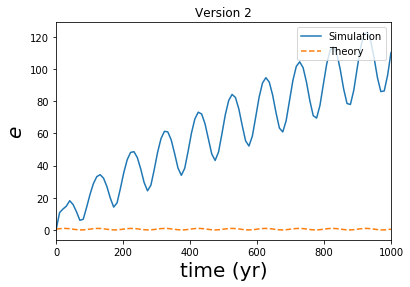

In [44]:
Mstar = sim.particles[0].m
Mp = sim.particles[1].m
e_theory = theoryEvolution(e0,times,τ,'trig')
#fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(11,11)) 
fig, ax1 = plt.subplots(1, 1, sharex=True,figsize=(6,4))
plt.subplots_adjust(wspace=0, hspace=0)
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)

#ax1.set_title(r'$(M_{\mathrm{star}},M_{P})=($'+str(Mstar)+'$,$'+str(Mp)+'$)$',fontsize=20)
ax1.set_title("Version 2")
ax1.plot(times,e,label='Simulation')
ax1.set_ylabel(r'$e$ ',fontsize=20)
ax1.set_xlabel('time (yr)', fontsize=20)
ax1.plot(times,e_theory,'--',label='Theory')
#ax1.set_ylim(e0*0.9,e0*1.1)
#ax1.axhline(y=1,color='black')
#ax1.axvline(x=5,color='black')
ax1.legend(loc="upper right")

#ax2.plot(times,a)
#ax2.plot(times,y,label=r'$y$')
#ax2.plot(times,z,label=r'$z$')
#ax2.set_ylabel('Semimajor axis (AU)',fontsize=20)
#ax2.set_xlabel('time (yr)', fontsize=20)
#plt.legend()

datestamp = str(datetime.datetime.now()).replace(" ","_")
savetag = 'orbitalEvolution_'
savetype = '.png'

plt.savefig('plots/'+savetag+datestamp+savetype,dpi=100,bbox_inches='tight')

# References

Murray, C. D., & Dermott, S. F. 1999, Solar System Dynamics (Cambridge University Press, New York)

Wolff, S., Dawson, R. I., & Murray-Clay, R. A. 2012, ApJ, 746, 171